In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sqlalchemy as db

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim import Adam

Connection to DLSU Cloud DB (PAL)
- `connection.json` is abstracted for data privacy

In [2]:
conn = pd.read_json('connection.json', typ='series')
host = conn['host']
user = conn['user']
password = conn['password']
port = conn['port']

db_name = input('DB Name: ')
engine = db.create_engine('mysql+pymysql://' + user + ':' + password + '@' + host + ':' + port + '/' + db_name)

DB Name: Historical


Reading the Historical Data

In [3]:
query = "SELECT * FROM PALB777_hour"
hist = pd.read_sql(query, engine)

# EDA & Preprocessing

In [4]:
hist.index = hist['index']
hist.drop('index', axis=1, inplace=True)

In [5]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15167 entries, 2022-01-01 00:00:00 to 2023-09-24 22:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rp7772  15167 non-null  float64
 1   rp7773  15167 non-null  float64
 2   rp7774  15167 non-null  float64
 3   rp7775  15167 non-null  float64
 4   rp7776  15167 non-null  float64
 5   rp7777  15167 non-null  float64
 6   rp7778  15167 non-null  float64
 7   rp7779  15167 non-null  float64
 8   rp7782  15167 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [6]:
hist.describe()

,rp7772,rp7773,rp7774,rp7775,rp7776,rp7777,rp7778,rp7779,rp7782
count,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000
mean,9084.342686,5085.247437,569.734959,3459.848711,3675.624093,4694.237881,5817.094252,5701.875285,6154.639672
std,10095.576421,8944.019925,3508.308840,7782.193918,7986.441379,8816.908037,9064.834853,9137.011880,9668.689192
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1762.191111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17731.146667,11142.077778,0.000000,0.000000,0.000000,761.437778,15609.200000,15453.533333,15790.866667
max,47314.755556,45496.164444,44033.791111,59026.795556,51505.040000,52611.413333,43916.324444,52218.631111,82163.244444


Separate the data

In [7]:
rp72 = hist[['rp7772']].rename({'rp7772':'ff'}, axis=1)
rp73 = hist[['rp7773']].rename({'rp7773':'ff'}, axis=1)
rp74 = hist[['rp7774']].rename({'rp7774':'ff'}, axis=1)
rp75 = hist[['rp7775']].rename({'rp7775':'ff'}, axis=1)
rp76 = hist[['rp7776']].rename({'rp7776':'ff'}, axis=1)
rp77 = hist[['rp7777']].rename({'rp7777':'ff'}, axis=1)
rp78 = hist[['rp7778']].rename({'rp7778':'ff'}, axis=1)
rp79 = hist[['rp7779']].rename({'rp7779':'ff'}, axis=1)
rp782 = hist[['rp7782']].rename({'rp7782':'ff'}, axis=1)

Process the main data (rp7772)

In [8]:
ss = StandardScaler()
ss.fit(rp72) # main data for standardization
time_step = 24*17 # time step for preprocessing

def time_step_prep(data, time_step):
    X = []
    y = []
    for i in range(time_step, data.shape[0]):
        X.append(list(data.iloc[i-time_step:i, 0].values.reshape(-1)))
        y.append(data.iloc[i, 0])
    return X, y

In [9]:
n_rp72 = pd.DataFrame(ss.transform(rp72))
X, y = time_step_prep(n_rp72, time_step)
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=0.5, shuffle=False)

Add more data to training set

In [10]:
n_rp = [rp73,rp74,rp75,rp76,rp77,rp78,rp79,rp782]

In [11]:
for each in n_rp:
    n_each = pd.DataFrame(ss.transform(each))
    n_X, n_y = time_step_prep(n_each, time_step)
    X_train = np.concatenate([X_train, np.array(n_X)])
    y_train = np.concatenate([y_train, np.array(n_y)])

Convert the data to torch

In [12]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# Autoregressive Model

Construct Autoregressive Model

In [13]:
auto_reg = nn.Linear(time_step,1)
optimizer = torch.optim.Adam(auto_reg.parameters(), lr=0.1)
loss_fun = nn.MSELoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.1)

In [14]:
def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               scheduler=None,
               epochs=500):
    
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred, y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        # scheduler
        if scheduler is not None:
            scheduler.step()
        
        if (epoch+1) % 5 ==0:
            print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
    return train_loss, test_loss

In [15]:
train_loss, test_loss = train_model(
    auto_reg, 
    loss_fun,
    optimizer, 
    X_train, 
    X_test, 
    y_train.reshape(-1,1), 
    y_test.reshape(-1,1),
    scheduler,
    10_000
)

Epoch :0.0005    Train Loss :402.37286376953125    Test Loss :85.39950561523438
Epoch :0.001    Train Loss :196.453857421875    Test Loss :53.19805908203125
Epoch :0.0015    Train Loss :73.74109649658203    Test Loss :31.92652702331543
Epoch :0.002    Train Loss :13.448376655578613    Test Loss :14.213546752929688
Epoch :0.0025    Train Loss :0.3808073401451111    Test Loss :3.9479241371154785
Epoch :0.003    Train Loss :3.5637335777282715    Test Loss :0.9961813688278198
Epoch :0.0035    Train Loss :6.304013729095459    Test Loss :0.646848201751709
Epoch :0.004    Train Loss :6.100890159606934    Test Loss :0.7588191032409668
Epoch :0.0045    Train Loss :4.610188961029053    Test Loss :0.8080121874809265
Epoch :0.005    Train Loss :3.088002920150757    Test Loss :0.6932471394538879
Epoch :0.0055    Train Loss :1.933124303817749    Test Loss :0.6132678389549255
Epoch :0.006    Train Loss :1.1496926546096802    Test Loss :0.5201933979988098
Epoch :0.0065    Train Loss :0.654053747653961

Epoch :0.0515    Train Loss :0.14533869922161102    Test Loss :0.30180731415748596
Epoch :0.052    Train Loss :0.1452731341123581    Test Loss :0.301681786775589
Epoch :0.0525    Train Loss :0.1452101767063141    Test Loss :0.30156195163726807
Epoch :0.053    Train Loss :0.14514970779418945    Test Loss :0.30144742131233215
Epoch :0.0535    Train Loss :0.14509165287017822    Test Loss :0.3013381063938141
Epoch :0.054    Train Loss :0.14503589272499084    Test Loss :0.3012337386608124
Epoch :0.0545    Train Loss :0.14498236775398254    Test Loss :0.30113425850868225
Epoch :0.055    Train Loss :0.14493095874786377    Test Loss :0.3010393977165222
Epoch :0.0555    Train Loss :0.14488163590431213    Test Loss :0.30094894766807556
Epoch :0.056    Train Loss :0.14483428001403809    Test Loss :0.30086272954940796
Epoch :0.0565    Train Loss :0.14478881657123566    Test Loss :0.30078062415122986
Epoch :0.057    Train Loss :0.14474520087242126    Test Loss :0.30070245265960693
Epoch :0.0575    

Epoch :0.102    Train Loss :0.14376863837242126    Test Loss :0.29964953660964966
Epoch :0.1025    Train Loss :0.14376796782016754    Test Loss :0.2996539771556854
Epoch :0.103    Train Loss :0.1437673270702362    Test Loss :0.29965826869010925
Epoch :0.1035    Train Loss :0.14376673102378845    Test Loss :0.29966267943382263
Epoch :0.104    Train Loss :0.1437661349773407    Test Loss :0.2996669411659241
Epoch :0.1045    Train Loss :0.1437656134366989    Test Loss :0.29967111349105835
Epoch :0.105    Train Loss :0.14376507699489594    Test Loss :0.2996753454208374
Epoch :0.1055    Train Loss :0.14376458525657654    Test Loss :0.2996794283390045
Epoch :0.106    Train Loss :0.14376410841941833    Test Loss :0.2996835708618164
Epoch :0.1065    Train Loss :0.1437636762857437    Test Loss :0.29968759417533875
Epoch :0.107    Train Loss :0.1437632441520691    Test Loss :0.2996915578842163
Epoch :0.1075    Train Loss :0.14376285672187805    Test Loss :0.2996954619884491
Epoch :0.108    Train 

Epoch :0.153    Train Loss :0.14375589787960052    Test Loss :0.2998538613319397
Epoch :0.1535    Train Loss :0.14375589787960052    Test Loss :0.29985424876213074
Epoch :0.154    Train Loss :0.14375589787960052    Test Loss :0.2998546361923218
Epoch :0.1545    Train Loss :0.14375588297843933    Test Loss :0.29985499382019043
Epoch :0.155    Train Loss :0.14375589787960052    Test Loss :0.29985538125038147
Epoch :0.1555    Train Loss :0.14375589787960052    Test Loss :0.2998557388782501
Epoch :0.156    Train Loss :0.14375589787960052    Test Loss :0.2998560965061188
Epoch :0.1565    Train Loss :0.14375585317611694    Test Loss :0.29985642433166504
Epoch :0.157    Train Loss :0.14375588297843933    Test Loss :0.2998567521572113
Epoch :0.1575    Train Loss :0.14375588297843933    Test Loss :0.29985707998275757
Epoch :0.158    Train Loss :0.14375589787960052    Test Loss :0.29985734820365906
Epoch :0.1585    Train Loss :0.14375588297843933    Test Loss :0.29985761642456055
Epoch :0.159   

Epoch :0.2035    Train Loss :0.14375585317611694    Test Loss :0.2998654246330261
Epoch :0.204    Train Loss :0.14375585317611694    Test Loss :0.2998654246330261
Epoch :0.2045    Train Loss :0.14375585317611694    Test Loss :0.2998654246330261
Epoch :0.205    Train Loss :0.14375585317611694    Test Loss :0.2998654246330261
Epoch :0.2055    Train Loss :0.14375588297843933    Test Loss :0.2998654544353485
Epoch :0.206    Train Loss :0.14375585317611694    Test Loss :0.2998654544353485
Epoch :0.2065    Train Loss :0.14375585317611694    Test Loss :0.2998654842376709
Epoch :0.207    Train Loss :0.14375588297843933    Test Loss :0.2998654842376709
Epoch :0.2075    Train Loss :0.14375585317611694    Test Loss :0.2998654544353485
Epoch :0.208    Train Loss :0.14375585317611694    Test Loss :0.2998659014701843
Epoch :0.2085    Train Loss :0.1437559872865677    Test Loss :0.299857497215271
Epoch :0.209    Train Loss :0.14380167424678802    Test Loss :0.3000680208206177
Epoch :0.2095    Train L

Epoch :0.2545    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.255    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.2555    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.256    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.2565    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.257    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.2575    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.258    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.2585    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.259    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.2595    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.26    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.260

Epoch :0.305    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.3055    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.306    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.3065    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.307    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.3075    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.308    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.3085    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.309    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.3095    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.31    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.3105    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.311  

Epoch :0.355    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.3555    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.356    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.3565    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.357    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.3575    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.358    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.3585    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.359    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.3595    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.36    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.3605    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.361  

Epoch :0.406    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.4065    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.407    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4075    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.408    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4085    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.409    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4095    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.41    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4105    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.411    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4115    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.412    Train L

Epoch :0.457    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4575    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.458    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4585    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.459    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4595    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.46    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4605    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.461    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4615    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.462    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4625    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.463    Train L

Epoch :0.508    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5085    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.509    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5095    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.51    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5105    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.511    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5115    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.512    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5125    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.513    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5135    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.514    Train L

Epoch :0.559    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5595    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.56    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5605    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.561    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5615    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.562    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5625    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.563    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5635    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.564    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5645    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.565    Train L

Epoch :0.61    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6105    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.611    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6115    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.612    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6125    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.613    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6135    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.614    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6145    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.615    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6155    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.616    Train L

Epoch :0.661    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6615    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.662    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6625    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.663    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6635    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.664    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6645    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.665    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6655    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.666    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6665    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.667    Train 

Epoch :0.712    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7125    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.713    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7135    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.714    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7145    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.715    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7155    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.716    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7165    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.717    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7175    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.718    Train 

Epoch :0.763    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7635    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.764    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7645    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.765    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7655    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.766    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7665    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.767    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7675    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.768    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7685    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.769    Train 

Epoch :0.814    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8145    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.815    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8155    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.816    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8165    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.817    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8175    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.818    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8185    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.819    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8195    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.82    Train L

Epoch :0.8645    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.865    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8655    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.866    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8665    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.867    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8675    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.868    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8685    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.869    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8695    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.87    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8705    Train 

Epoch :0.915    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9155    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.916    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9165    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.917    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9175    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.918    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9185    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.919    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9195    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.92    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9205    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.921    Train L

Epoch :0.966    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9665    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.967    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9675    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.968    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9685    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.969    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9695    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.97    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9705    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.971    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9715    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.972    Train L

In [ ]:
ax = plt.subplot()
ax.plot(train_loss, label='Train Loss')
ax.plot(test_loss, label='Test Loss')
ax.legend()

Single-step prediction

In [55]:
actual = pd.DataFrame(ss.inverse_transform(y_test.detach().numpy().reshape(-1,1))).rename({0:'actual'},axis=1)
pred = pd.DataFrame(ss.inverse_transform(auto_reg(X_test).detach().numpy())).rename({0:'single_pred'},axis=1)

<Axes: >

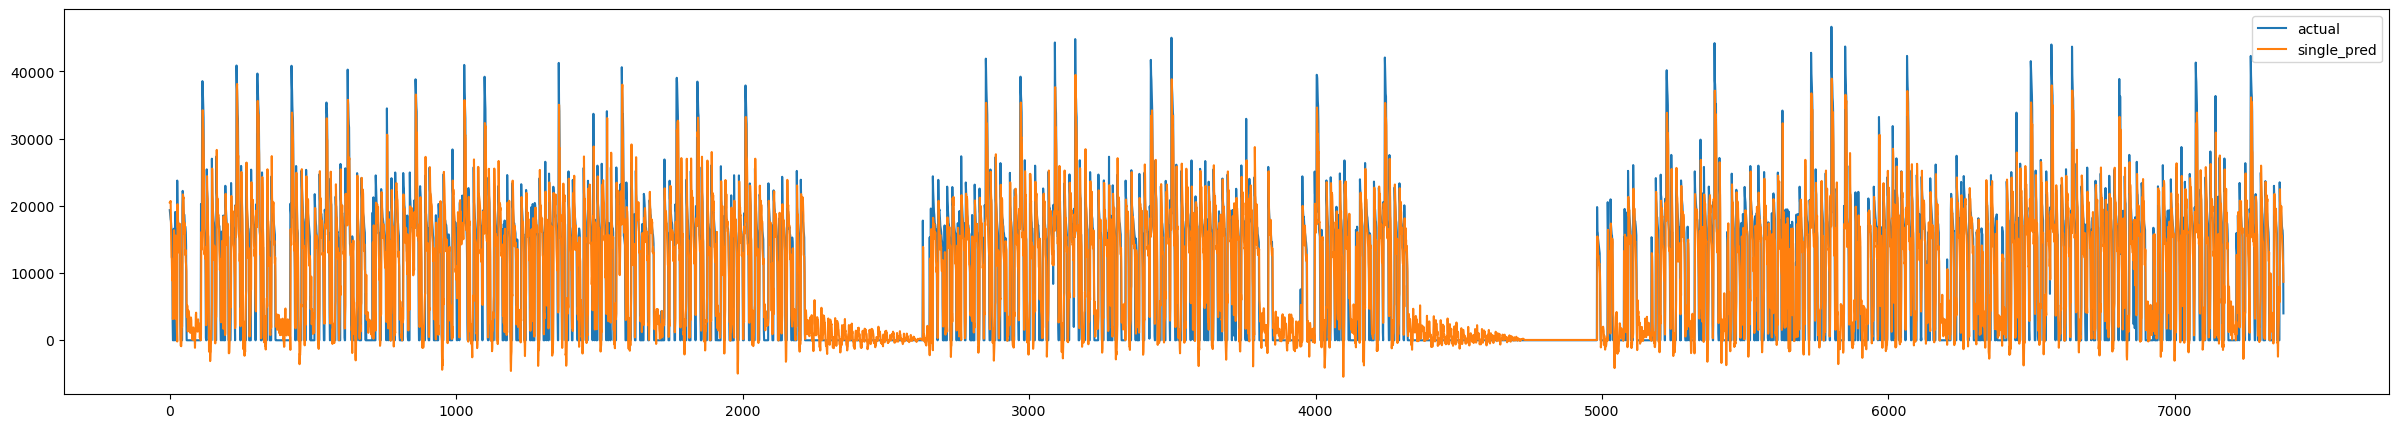

In [56]:
actual_pred = pd.concat([actual, pred], axis=1)
actual_pred.plot(figsize=(30,5))

In [57]:
rmse = float(np.sqrt(sum((actual.values - pred.values)**2)/len(actual)))
r2 = r2_score(actual, pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 5528.14501953125
R2: 0.7082307282770433


Multi-step prediction

In [58]:
multi_pred = []
currX = X_test[0]

while len(multi_pred) != len(X_test):
    tensor_pred = auto_reg(currX)
    currX = torch.cat([currX, tensor_pred])
    currX = currX[-time_step:]
    pred = ss.inverse_transform(tensor_pred.detach().numpy().reshape(-1,1))
    multi_pred.append(float(pred))

In [59]:
pred_step = pd.DataFrame({"multi_pred":multi_pred})
pred_step.index = actual_pred.index

<Axes: >

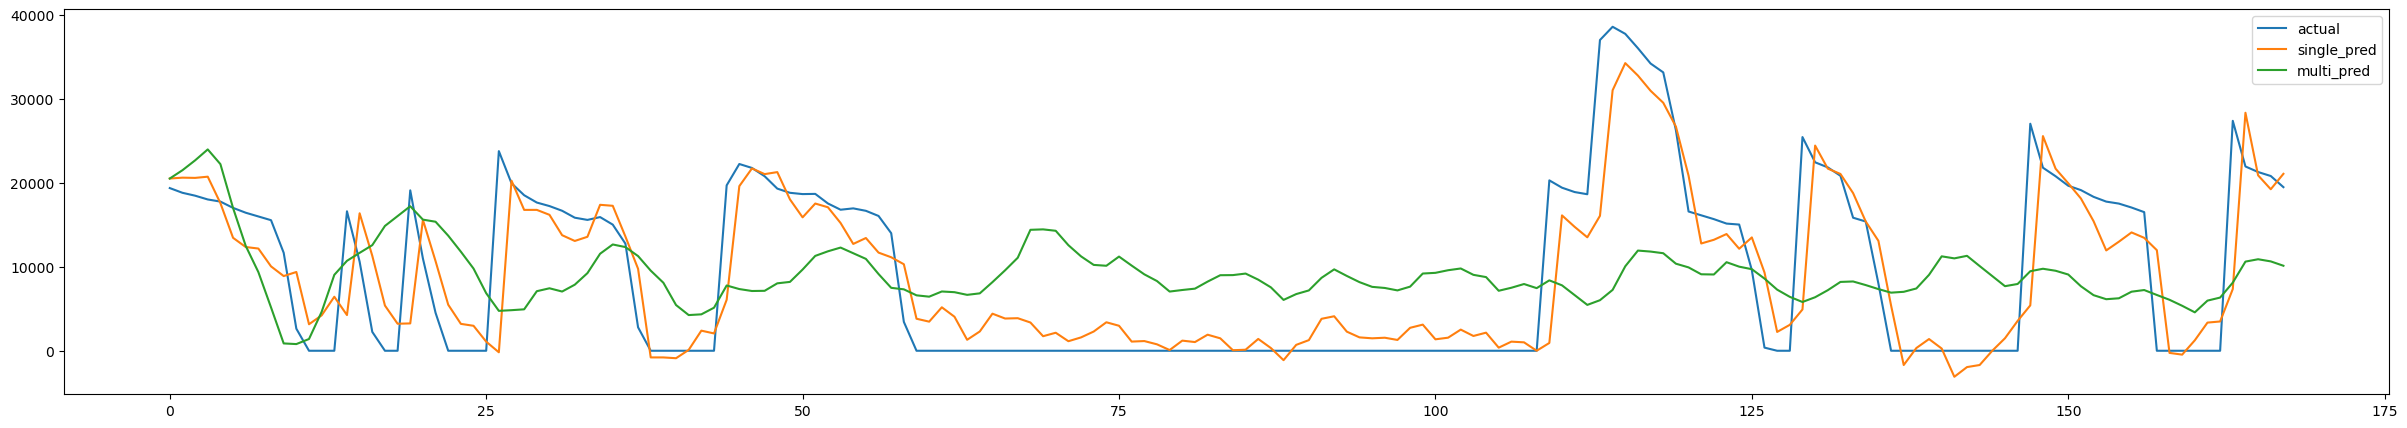

In [60]:
pd.concat([actual_pred, pred_step], axis=1)[:24*7].plot(figsize=(30,5))

In [74]:
pd.concat([actual_pred, pred_step], axis=1)[:24*7].sum().reset_index()

,index,0
0,actual,1.533315e+06
1,single_pred,1.507399e+06
2,multi_pred,1.533722e+06


In [117]:
def sampler(time_step, model=None):
    date = '2022-05-05'
    plane = 'rp7772'
    i = pd.to_datetime(date)
    
    ss = StandardScaler()
    train_X = hist['rp7772'][i - pd.Timedelta(hours=time_step):i-pd.Timedelta(hours=1)].values.reshape(-1,1)
    n_train_X = ss.fit_transform(train_X)
    n_train_X = torch.from_numpy(n_train_X.astype(np.float32))
    print(n_train_X)
sampler(time_step, model=auto_reg)

tensor([[-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [ 1.8485],
        [ 1.5805],
        [ 1.5280],
        [ 1.4408],
        [ 1.3474],
        [ 1.2827],
        [ 1.1952],
        [ 1.1416],
        [ 1.0816],
        [ 1.0040],
        [ 0.9432],
        [ 0.9039],
        [ 0.8369],
        [ 0.8166],
        [-0.4047],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.9250],
        [-0.

In [94]:
date = '2022-05-05'
plane = 'rp7772'
i = pd.to_datetime(date)
print(hist[plane][i])

0.0


In [113]:
hist['rp7772'][i - pd.Timedelta(hours=time_step):i-pd.Timedelta(hours=1)].values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.50245022e+04, 2.26068444e+04,
       2.21329244e+04, 2.13456711e+04, 2.05032222e+04, 1.99197200e+04,
       1.91303956e+04, 1.86462667e+04, 1.81046756e+04, 1.74047822e+04,
       1.68567111e+04, 1.65016978e+04, 1.58975733e+04, 1.57135333e+04,
       4.69441778e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [100]:
time_step

408

In [106]:
hist['rp7772']

index
2022-04-18 00:00:00        0.000000
2022-04-18 01:00:00        0.000000
2022-04-18 02:00:00        0.000000
2022-04-18 03:00:00        0.000000
2022-04-18 04:00:00        0.000000
                           ...     
2022-05-04 19:00:00    18347.035556
2022-05-04 20:00:00    17405.435556
2022-05-04 21:00:00    16919.240000
2022-05-04 22:00:00    16497.666667
2022-05-04 23:00:00    16053.208889
Name: rp7772, Length: 408, dtype: float64